# EDA.ipynb

## Explore the (downsampled) data

In [1]:
# imports:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# import utils and other models
import utils
import bla_avg_model

In [2]:
# load in cleaned data: 
input_file = "dataset1_clean.csv"
data = pd.read_csv(input_file, index_col=[0], skipinitialspace=True)
#print(data.head())

In [3]:
# convert the train and validation dataframes into a set of np arrays that can be more readily used to train models
X_95th, X_median, X_5th = utils.split_X_into_quantiles(data)
Y_95th, Y_median, Y_5th = utils.split_Y_into_beams_and_quantiles(data)

## Explore dimensionality reduction

In [4]:
# first: PCA
# run PCA keeping all components
all_comp = PCA()
all_comp.fit(X_median)

PCA()

[2.95835273e+02 2.18227304e+02 1.58797184e+02 1.14765119e+02
 9.71103983e+01 6.19371840e+01 9.64473149e+00 2.18226241e+00
 1.83289359e+00 1.42686442e+00 6.66400075e-01 2.89944457e-01
 1.15139885e-02 1.73778752e-07 1.34077971e-10 1.35656410e-13
 6.70540679e-14 4.93874846e-14 2.94454742e-14 2.66377058e-14
 2.66377058e-14 2.66377058e-14 2.66377058e-14 2.66377058e-14
 2.66377058e-14 2.66377058e-14 2.66377058e-14 2.66377058e-14
 2.66377058e-14 2.66377058e-14 2.66377058e-14 2.66377058e-14
 2.66377058e-14 2.66377058e-14 2.66377058e-14 2.66377058e-14
 2.66377058e-14 2.66377058e-14 2.66377058e-14 2.65376270e-14
 1.38865200e-14]


[]

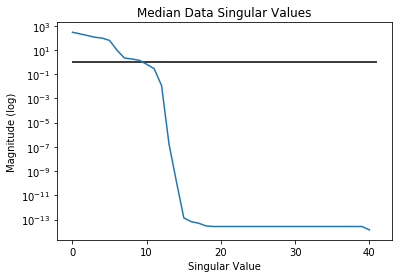

In [5]:
print(all_comp.singular_values_)
plt.yscale("log")
plt.plot(all_comp.singular_values_)
plt.hlines(1, 0, 41)
plt.ylabel("Magnitude (log)")
plt.xlabel("Singular Value")
plt.title("Median Data Singular Values")
plt.plot()

Singular Values > 1: ( 10 )  [295.83527306 218.2273037  158.79718373 114.76511892  97.11039826
  61.93718405   9.64473149   2.18226241   1.83289359   1.42686442]


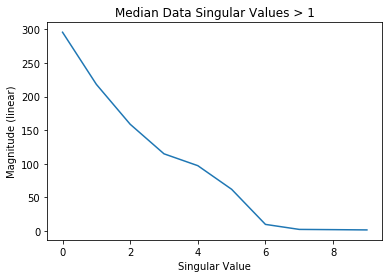

In [6]:
sv_gt1 = all_comp.singular_values_[all_comp.singular_values_ > 1]
plt.yscale("linear")
plt.plot(sv_gt1)
plt.ylabel("Magnitude (linear)")
plt.xlabel("Singular Value")
plt.title("Median Data Singular Values > 1")
plt.plot()
print("Singular Values > 1: (", len(sv_gt1), ") ", sv_gt1)

In [13]:
evr = all_comp.explained_variance_ratio_[:10]
print("Explained Variance (ratio) for top 10 components: ", evr)
print("Total Proportion of Variance Explained:")
print("Top 10:", np.sum(evr))
print("Top 6: ", np.sum(evr[:6]))
print("Top 3: ", np.sum(evr[:3]))


Explained Variance (ratio) for first 10 components:  [4.68264842e-01 2.54806097e-01 1.34920280e-01 7.04711671e-02
 5.04571960e-02 2.05255383e-02 4.97704909e-04 2.54803615e-05
 1.79748861e-05 1.08932397e-05]
Total Proportion of Variance Explained:
Top 10: 0.9999971734052013
Top 6:  0.9994451200084583
Top 3:  0.8579912186329963


Looking at the singular values generated from running PCA, we can see that there are 10 singular values with magnitude
greater than 1. Of these values, the largest is ~296, and the smallest is 1.42. There are 6 values with magnitude much
greater than the others (>60 vs <10). Considering the values with small magnitudes, we see that there are ~25 values 
with magnitudes on the order of 10^-14, and several more with larger but still quite small values. 

Results like this are to be expected, because a large number of columns in our dataset have very little variance, if
any. The small number of significant singular values suggests that dimensionality reduction would help reduce model
complexity when training models against this problem.

In [48]:
cols = utils.select_one_quantile(utils.select_non_bla(data.columns), "median")
# Exploring the top 10 components:
top_10_comp = all_comp.components_[:10]

all_cols_in_top = []
threshold = .001
for i in range(len(top_10_comp)):
    col_indices = np.nonzero(top_10_comp[i] > threshold)[0]
    #print(col_indices)
    top_cols = [(cols[j], top_10_comp[i][j]) for j in col_indices]

    top_cols.sort(reverse=True, key=lambda x: x[1])
    
    for col in top_cols:
        all_cols_in_top.append(col[0])
    
    print("Component %d:" % i) 
    print(top_cols)
    
all_cols_in_top.sort()
all_cols_in_top = set(all_cols_in_top)
print("All columns in top singular values: ", all_cols_in_top)
print(len(all_cols_in_top))

Component 0:
[('Extractor_2_median', 0.14462156427569747), ('Extractor_4_median', 0.07696374047464524)]
Component 1:
[('Extractor_6_median', 0.7341466325404346), ('Extractor_1_median', 0.2122202518069216), ('Faraday_Cup_6_median', 0.02278906315964984), ('Faraday_Cup_1_median', 0.006594565336326034)]
Component 2:
[('Extractor_6_median', 0.46165763786533914), ('Extractor_4_median', 0.36663224366373787), ('Extractor_3_median', 0.3541107364512992), ('Extractor_2_median', 0.0685233034781904), ('Faraday_Cup_3_median', 0.025237440911887815), ('Faraday_Cup_6_median', 0.01761235999971853), ('Faraday_Cup_4_median', 0.017550829157534788), ('Faraday_Cup_2_median', 0.0014769192325866448)]
Component 3:
[('Extractor_5_median', 0.7250001375497019), ('Extractor_6_median', 0.31068736063489955), ('Extractor_2_median', 0.010619143674019211), ('Faraday_Cup_6_median', 0.006667985085449564)]
Component 4:
[('Extractor_4_median', 0.727532741335063), ('Extractor_5_median', 0.5870444807238792), ('Extractor_1_med

Analysis of Component Vectors:

12 columns appear in the top 10 component vectors. These columns consist of the 6 extractor columns and the 6 faraday
cup columns. None of the DAC output or voltage output columns made it to this list, which makes sense because most of
those columns have constant or almost-constant values across the entire dataset.
